### LOGISTIC REGRESSION
In this assignment we try to find a relation between average weight of granules and total surface area to see if a material is viable as a catalyst

In [101]:
# Importing libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Feature mapping
Sometimes, we are given an inadequate number of features for which training the dataset becomes difficult.  
Hence we create new features of by taking polynomial products of existing ones.

In [102]:
# Generates new features by taking products of various powers of the input features (x and y)
# This expands the feature space with polynomial combinations (up to degree 4) of x and y

### TODO 1
def feature_map(points):
    points = np.array(points)
    
    x, y = points[:, 0], points[:, 1]
    
    # YOUR CODE HERE
    features = x
    # Append different terms such as x, y^2, x^2y and so on upto degree 4 terms
    for i in range(5):
        features = np.vstack((features, (x**i)*(y**(4-i))))
    for i in range(4):
        features = np.vstack((features, (x**i)*(y**(3-i))))
    for i in range(3):
        features = np.vstack((features, (x**i)*(y**(2-i))))

    features = np.vstack((features, y))

    
    return np.column_stack(features)

### Creating the class for Logistic Regression

In [103]:
# Our class in which we define all functions. (This way our functions are contained)
class LogisticRegression:

    # Constructor (weights and bias are member variables)
    # Can be accessed via self.weights and self.bias
    def __init__(self) -> None:
        self.weights : np.ndarray | None = None
        self.bias : float | None = None



    # Sigmoid function
    ### TODO 2
    def __sigmoid(self, z: np.ndarray) -> np.ndarray:
        # YOUR CODE HERE
        return 1/(np.exp(-z) + 1)


    
    # Returns probabilities of being true
    ### TODO 3
    def predict_probability(self, X: np.ndarray) -> np.ndarray:
        # YOUR CODE HERE
        z = np.dot(X, self.weights) + self.bias
        #print(z)
        return self.__sigmoid(z)



    # Returns true/false (based on the probabilities)
    ### TODO 4
    def predict(self, X: np.ndarray) -> np.ndarray:
        # YOUR CODE HERE
        #print(self.predict_probability(X))
        return (self.predict_probability(X) >= 0.5)
    

    
    # Returns loss or cost, change in weights (dw), change in bias (db) with regularization
    ### TODO 5 
    def __loss(self, X: np.ndarray, y: np.ndarray, lambda_reg: float = 0) -> tuple:
        # Add code here
        n = len(X)

        x = self.predict_probability(X)
        _loss = -y*np.log(x) - (1-y)*np.log(1 - x)
        #print("_loss", _loss)
        loss = np.sum(_loss)/(2*n)
        #print(loss)

        diff = x - y
        #print("diff*X", np.shape(diff*X))

        dw = np.sum(diff*X, axis=0)/n
        dw = np.reshape(dw, (len(dw), 1))
        db = np.sum(diff)/n

        #print(np.shape(diff), np.shape(X), np.shape(dw), np.shape(self.weights), np.shape(loss))

        # L2 Regularization
        
        loss += np.sum(self.weights ** 2, axis=0)*lambda_reg/(2*n) ## Change this line
        #print(loss)
        dw += (self.weights)*lambda_reg/n ## Change this line

        return loss, dw, db
    


    # Adjusts the weights and bias to get the minimum loss
    ### TODO 6
    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 500,
            learning_rate: float = 0.1, threshold: float = 0.0001, 
            lambda_reg: float = 1) -> None:
        
        # Randomise initial weights and bias
        # YOUR CODE HERE
        self.weights = np.zeros((len(X[0]), 1))
        self.bias = 0

        loss, dw, db = self.__loss(X, y, lambda_reg)

        # Gradient descent
        for i in range(epochs):
            # Logic for gradient descent
            # YOUR CODE HERE
            # print("iteration", i)
            # print("loss", loss)
            #print(f"dw {dw}, db {db}")
            #print("weights", self.weights)
            # print("biases", self.bias)
            # print("feature map", feature_map([[1, 1], [2, 2]]))
            # z = np.dot(feature_map([[1, 1], [2, 2]]), self.weights) + self.bias
            # print("Z", z)
            # print("sigmoid", self.__sigmoid(z))
            # print("probablitites", self.predict_probability(feature_map([[1, 1], [2, 2]])))

            self.weights = self.weights - learning_rate*dw
            self.bias -= learning_rate*db

            loss_new, dw, db = self.__loss(X, y, lambda_reg)

            if loss - loss_new < threshold:
                return

            loss = loss_new
            #print(i)
            i += 1

        return

In [104]:
# Importing data
df = pd.read_csv('logistic_data.csv')
data = df.to_numpy()
X = data[:, :2]
y = data[:, 2].reshape((len(data), 1))

In [105]:
# Creating train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
# z-score standardization
### TODO 7
def z_score(X: np.ndarray) -> tuple:
    # Add code here
    x_mean = np.mean(X, axis = 0)
    x_std = np.std(X, axis = 0)
    x = (X - x_mean)/x_std
    return x, x_mean, x_std

In [107]:
# Normalizing the data (we use the same constants to maintain consistency)
X_train, x_mean, x_std = z_score(X_train)
X_test = (X_test - x_mean) / x_std
x_train = feature_map(X_train)
x_test = feature_map(X_test)

In [108]:
# Visualizing how the boundary curve looks like
def plot_decision_boundary(X_original, y, model, resolution=500):
    # Set up the grid for the decision boundary
    x_min, x_max = X_original[:, 0].min() - 1, X_original[:, 0].max() + 1
    y_min, y_max = X_original[:, 1].min() - 1, X_original[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    
    # Flatten the grid points and map to expanded features
    grid_original = np.c_[xx.ravel(), yy.ravel()]
    grid_expanded = feature_map(grid_original)
    
    # Predict the grid values for decision boundary
    Z = model.predict(grid_expanded)
    #print(Z)
    Z = Z.reshape(xx.shape)
    
    # Plot the data points
    y = np.reshape(y, len(y))
    true_points = X_original[y == 1]
    false_points = X_original[y == 0]
    plt.scatter(true_points[:, 0], true_points[:, 1], label="True", c="blue", marker="o", s=20)
    plt.scatter(false_points[:, 0], false_points[:, 1], label="False", c="red", marker="x", s=20)

    # Plot the decision boundary
    plt.contour(xx, yy, Z, levels=[0.5], colors="black", linewidths=2)
    
    # Labeling and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary and Data Points")
    plt.legend()
    plt.show()

We plot the decision boundary that the model predicts. This can be used to check for overfitting.  
If the boundary starts looking like an ameoba trying to fit every point, then it is a sign of overfitting.

Your model has an accuracy of 95.0%


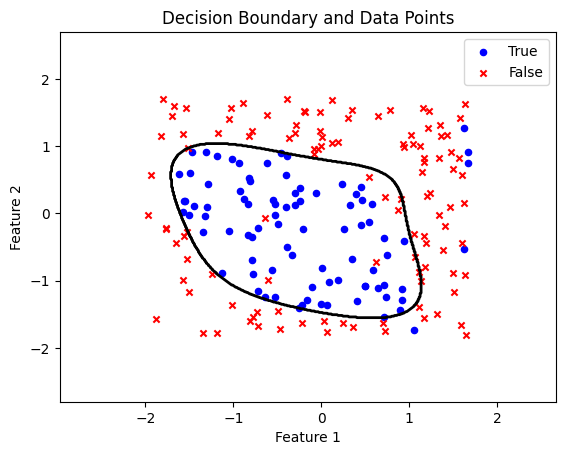

In [109]:
# Checking accuracy of test model
model = LogisticRegression()
model.fit(x_train, y_train, lambda_reg=12)
y_pred = model.predict(x_test)

accuracy = np.mean(y_pred == y_test) * 100
print(f"Your model has an accuracy of {accuracy}%")
#print(y_pred)

# Plotting the contour and checking for overfitting (try changing the degree in the feature_map function to 10 instead)
plot_decision_boundary(((X - x_mean) / x_std), y, model)